In [ ]:
import cv2
import os
import random
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from tensorflow import keras
from keras.metrics import Precision, Recall,BinaryAccuracy
from keras import layers,optimizers,Model,utils,losses
import tensorflow as tf

In [ ]:
POS_PATH = os.path.join("data", 'positive')
NEG_PATH = os.path.join("data", 'negative')
ANC_PATH = os.path.join("data", 'new anchor')
NEW_NEG = os.path.join("data",'NEG_NEW')
real = os.path.join("data",'new anchor+')


In [ ]:
# Move LFW Images to the following repository lfw
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)


In [ ]:
# Modify LFW dataset
import shutil
for directory in os.listdir('lfw'):
   for file in os.listdir(os.path.join('lfw', directory)):
        num_copies = len(os.listdir(os.path.join('lfw', directory)))

        EX_PATH = os.path.join('C:\\Users\\Adam\\Desktop\\Face\\lfw', directory, file)
        if EX_PATH.endswith('0001.jpg'):
           z = EX_PATH
      
        for i in range((num_copies-1)):
         zc = f"{z}_{i+1}_0001.jpg"
         shutil.copy2(z,zc)


In [ ]:
# Modify LFW dataset
import shutil
for directory in os.listdir('lfw2'):
   for file in os.listdir(os.path.join('lfw2', directory)):
        EX_PATH = os.path.join('C:\\Users\\Adam\\Desktop\\Face\\lfw2', directory, file)
        if not EX_PATH.endswith('0001.jpg'):
          os.remove(EX_PATH)


In [ ]:
#Get Image Directories
reals = tf.data.Dataset.list_files(real+'/*.jpg',shuffle=False).take(4000)
positive = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg',shuffle=False).take(4000)
negative = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg',shuffle=False).skip(4000)
negative = negative.take(4000)

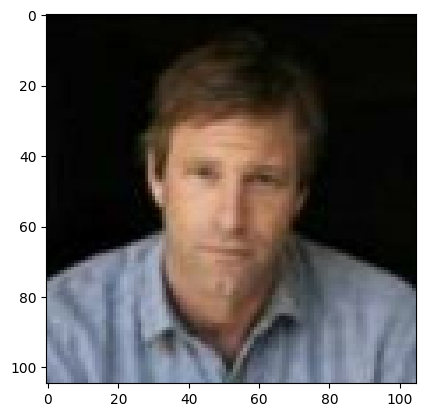

In [ ]:
#Preprocessing - Scale and Resize
def preprocess(file_path):

    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image
    img = tf.io.decode_jpeg(byte_img)

    # Preprocessing steps - resizing the image to be 105x105x3
    img = tf.image.resize(img, (105,105))
    # Scale image to be between 0 and 1
    img = img/255

    # Return image
    return img
img = preprocess(r"/content/drive/My Drive/Colab Notebooks/data/anchor/Aaron_Eckhart_0001.jpg")
img.numpy().min()
plt.imshow(img,cmap='gray')

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0
positives = tf.data.Dataset.zip((positive, reals, tf.data.Dataset.from_tensor_slices(tf.ones(len(positive)))))
negatives = tf.data.Dataset.zip((reals, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(positive)))))
data = positives.concatenate(negatives)
print(data)
print(type(data))
samples = []
for samples in data.as_numpy_iterator():
  print(samples)




In [ ]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)
#res = preprocess_twin(*exampple)
#res[2]
#plt.imshow(res[1])

In [ ]:
# Build dataloader pipeline
data=data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=10000)


In [ ]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
#start preprocessing the next set as NN not to stuck(bottelkneck)
train_data = train_data.prefetch(8)

In [ ]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [ ]:
#CNN
def make_analysis():

 input = layers.Input(shape=(105,105,3), name='input_image')

    # First block
 conv1 = layers.Conv2D(64, (10,10), activation='relu',strides=1)(input)
 max1 = layers.MaxPooling2D(64, (2,2), padding='same')(conv1)

    # Second block
 conv2 = layers.Conv2D(128, (7,7), activation='relu',strides=1)(max1)
 max2 = layers.MaxPooling2D(64, (2,2), padding='same')(conv2)

    # Third block
 conv3 = layers.Conv2D(128, (4,4), activation='relu',strides=1)(max2)
 max3 = layers.MaxPooling2D(64, (2,2), padding='same')(conv3)

    # Final embedding block
 conv4 = layers.Conv2D(256, (4,4), activation='relu',strides=1)(max3)
    #3D to 1D
 flat = layers.Flatten()(conv4)
    #Feature Vector
 res = layers.Dense(4096, activation='sigmoid')(flat)

 return Model(inputs=[input], outputs=[res], name='Analysis')

In [ ]:
Analysis=make_analysis()
Analysis.summary()

Model: "Analysis"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 105, 105, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 96, 96, 64)        19264     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 42, 42, 128)       401536    
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 21, 21, 128)      0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 18, 18, 128)       262

In [ ]:
#build a distance layer
# Siamese L1 Distance class
class L1Dist(layers.Layer):

    # Init method - inheritance #self to operate on itself
    # # **kwargs to use this as a part of bigger model(exporting & importing & specific key word)
    def __init__(self, **kwargs):
        super().__init__()

    ###### Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [ ]:
# Reload model
siamese_model = tf.keras.models.load_model('/content/drive/My Drive/train/siamesemodelv2 END new v40 enhancment with 4440 colored.h5', custom_objects={'L1Dist':L1Dist})

#predict
#siamese_model.predict([test_input, test_val])

# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 Analysis (Functional)          (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [ ]:
def make_siamese_model():

    # Anchor image input in the network
    input_image = layers.Input(name='input_img', shape=(105,105,3))

    # Validation image in the network
    validation_image = layers.Input(name='validation_img', shape=(105,105,3))

    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    print(Analysis(input_image))
    distances = siamese_layer(Analysis(input_image), Analysis(validation_image))

    # Classification layer
    classifier = layers.Dense(1, activation='sigmoid')(distances)

    return Model(inputs=[input_image, validation_image], outputs=[classifier], name='SiameseNetwork')

In [ ]:
siamese_network=make_siamese_model()
siamese_network.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 4096), dtype=tf.float32, name=None), name='Analysis/dense_1/Softmax:0', description="created by layer 'Analysis'")
Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 105, 105, 3  0           []                               
                                )]                                                                
                                                                                                  
 Analysis (Functional) 

In [ ]:
#Training
#setup loss and optimizer
binary_cross_loss = tf.losses.BinaryCrossentropy()
opt = optimizers.Adam(0.0001)



#train step function
#to train on one batch to calc. loss and inhance weights
#as it compile all NN into graph
@tf.function
def train_step(batch):

    # Record all of our operations inside NN to calc. gradients
    with tf.GradientTape() as tape:
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]

        # Forward pass # make a prediction
        y_train = siamese_network(X, training=True)
        # Calculate loss # by take a real value & predicted values
        loss = binary_cross_loss(y, y_train)
    print(loss)

    # Calculate gradients #train on all operations and use to calc. gradients
    gradients  = tape.gradient(loss, siamese_network.trainable_variables)

    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(gradients , siamese_network.trainable_variables))

    # Return loss
    return loss


In [ ]:
#Training
#training loop
# Import metric calculations
from keras.metrics import Precision, Recall, Accuracy
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))

        # Creating a metric object
        r = Recall()
        p = Precision()
        acc=BinaryAccuracy()

        # Loop through each batch # counter for the batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss=train_step(batch)
            yhat = siamese_network.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat)
            a=(2*(r.result().numpy())*(p.result().numpy()))/((r.result().numpy())+(p.result().numpy()))
            acc.update_state(batch[2],yhat)
            progbar.update(idx+1)
            #make progress on screen
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy(),a,acc.result().numpy())

In [ ]:
train(train_data,5)

In [ ]:
r = Recall()
p = Precision()
acc=BinaryAccuracy()
for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat)
    a=(2*(r.result().numpy())*(p.result().numpy()))/((r.result().numpy())+(p.result().numpy()))
    acc.update_state(y_true,yhat)
print(r.result().numpy(), p.result().numpy(),a,acc.result().numpy())

In [ ]:
#Save the model
# Save weights
siamese_model.save('/content/drive/My Drive/train/siamesemodelv2 END new v50 enhancment with 4440 colored.h5')

In [ ]:
#Real Time testing
os.listdir(os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'verification_images'))
os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'input_image', 'input_image.jpg')

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'verification_images')):
        input_img = preprocess(os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'verification_images', image))

        # Make Predictions (put arrays in another sets of array)
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)

    # Detection Threshold: Metric above which a prediciton is considered positive (50%=1)
    #summ all the examples that pass detection_threshold
    detection = np.sum(np.array(results) > detection_threshold)

    # Verification Threshold: Proportion of positive predictions / total positive samples
    verification = detection / len(os.listdir(os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'verification_images')))
    verified = verification > verification_threshold

    return results, verified

In [ ]:
results, verified = verify(siamese_network, 0.57, 0.8)
print(verified)
print(results)

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    #standered is 480*640 so we slice index it to 250*250 and : get all channels
    frame = frame[120:120+250,200:200+250, :]

    cv2.imshow('Verification', frame)

    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # Save input image to application_data/input_image folder
        cv2.imwrite(os.path.join('/content/drive/My Drive/Colab Notebooks/application_data', 'input_image', 'input_image.jpg'), frame)
        # Run verification
        results, verified = verify(siamese_model, 0.5, 0.5)
        print(verified)

    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

In [ ]:
np.sum(np.squeeze(results) > 0.58)


1